### Data Loading, Merging, and Cleaning

Location: 'data' folder.

Lucas Lobo

1. Description

Note: this can be copy-pasted into the 'Data Description' part in the Quarto report.

We chose to focus on the 'population dynamics' research question within the WDI Dataset. Specifically, we wanted to explored how various health-related, economic, and geographic factors contributed towards and interacted with life expectancy at birth, mortality rate, and adolescent fertility rate. Some of these factors (or 'services,' as named by the WDI) include immunization rates for DPT, HepB3, measles, prevalence of HIV, TB case detection rates, proportion of expenditure spent on health-related measures, urban and rural populations, unemployment rates, surface area, and rule of law estimates. To narrow our focus, we only included data from Central and South American countries: Argentina, Belize, Costa Rica, El Salvador, Guatemala, Honduras, Mexico, Nicaragua, Panama, Bolivia, Brazil, Chile, Colombia, Ecuador, Guyana, Paraguay, Peru, Suriname, Uruguay, Venezuela, Cuba, Dominican Republic, Haiti, Puerto Rico (territory), St. Martin. Finally, we included data from the past 50 years (1975-2024).

2. Loading + Creating the Database.

In [1]:
# Relevant packages:
import sqlite3
import pandas as pd

# Loading the WDI data as a csv (using pandas):
df = pd.read_csv(r"C:\Users\lcsrl\Downloads\QTM350 Final Project Data.csv", encoding='latin1')

# Created a database by running the following two commands in my terminal:
## cd "C:\Users\lcsrl\Downloads"
## touch qtm350_project.db

# Relevant packages:
import sqlite3
import pandas as pd

# Loading the WDI data as a csv (using pandas):
df = pd.read_csv(r"C:\Users\lcsrl\Downloads\QTM350 Final Project Data.csv", encoding='latin1')

# Created a database by running the following two commands in my terminal:
## cd "C:\Users\lcsrl\Downloads"
## touch qtm350_project.db

# Set up connection:
conn = sqlite3.connect(r"C:\Users\lcsrl\Downloads\qtm350_project.db")
cursor = conn.cursor()

# Write 'df' to SQL:
cursor.execute("DROP TABLE IF EXISTS wdi;")
df.to_sql('wdi', conn, if_exists='replace', index=False)

542

Opening 'qtm350_project.db': matches exactly.

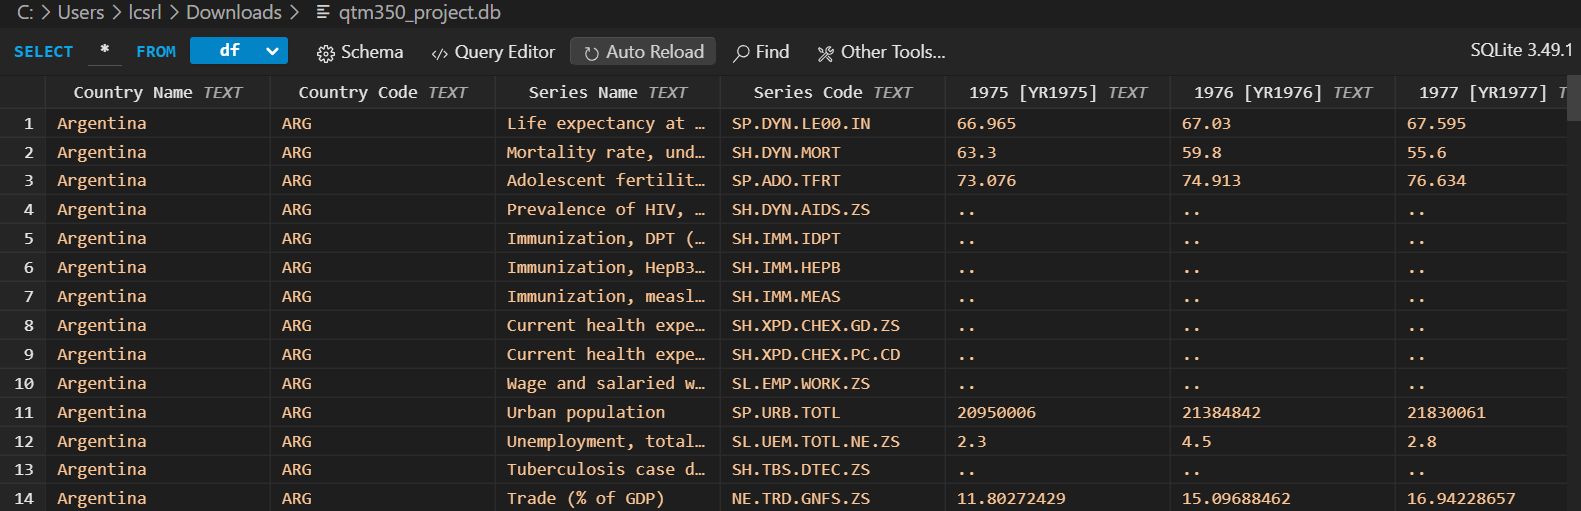

3. Data Cleaning + Transformation. Off the bat, there are lots of oddly-named variables and warped data. We'll create a new cleaned table. We'll drop/modify N/A values (denoted as ..) according to the following procedures.

In [2]:
# new, cleaned dataframe
# 1: create a new 'year' list (to replace the current format)
year_columns = [
    f'"{year} [YR{year}]" AS "{year}"' for year in range(1975, 2025)
]

# 2: new table only with relevant columns: country_name, indicator, and years 
cursor.execute("DROP TABLE IF EXISTS wdi_renamed;")
q_keep = f"""
CREATE TABLE wdi_renamed AS
SELECT 
    "Country Name" AS country_name,
    "Series Name" AS indicator,
    {', '.join(year_columns)}
FROM wdi
"""
conn.execute(q_keep)

In [3]:
pd.read_sql("SELECT * FROM wdi_renamed", conn).head()

,country_name,indicator,1975,1976,1977,1978,1979,1980,1981,1982,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Argentina,"Life expectancy at birth, total (years)",66.965,67.03,67.595,67.999,68.434,68.576,68.858,68.973,...,76.6,76.105,76.543,76.77,76.847,75.878,73.948,75.806,77.395,..
1,Argentina,"Mortality rate, under-5 (per 1,000 live births)",63.3,59.8,55.6,51.2,46.8,42.8,39.4,36.5,...,11.7,11.4,11,10.7,10.5,10.3,10,9.8,9.6,..
2,Argentina,"Adolescent fertility rate (births per 1,000 wo...",73.076,74.913,76.634,77.695,78.328,77.928,76.742,74.387,...,63.879,58.79,55.022,49.926,41.751,31.492,28.54,25.767,26.414,..
3,Argentina,"Prevalence of HIV, total (% of population ages...",..,..,..,..,..,..,..,..,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,..,..
4,Argentina,"Immunization, DPT (% of children ages 12-23 mo...",..,..,..,..,..,44,49,58,...,94,92,86,86,83,74,81,84,66,..


4. We will create a new column in wdi_renamed called 'region' that sorts the countries into three regions as follows:

Central America (9 countries): Belize, Costa Rica, El Salvador, Guatemala, Honduras, Nicaragua, Panama, Mexico, Bolivia, 

South America (10 countries): Argentina, Brazil, Chile, Colombia, Guyana, Paraguay, Peru, Suriname, Uruguay, Venezuela, RB. 

Caribbean (5 countries): Dominican Republic, Haiti, Jamaica, St. Martin (French part), Puerto Rico.

In [4]:
conn.execute("DROP TABLE IF EXISTS wdi_region;")

# writes an implicit 'if else' function in sql to create a new column 'region' based on the country name by using CASE WHEN/ELSE statements.
q_region = """
CREATE TABLE wdi_region AS
SELECT 
    country_name,
    CASE
        WHEN country_name IN (
            'Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama', 'Mexico', 'Bolivia'
        ) THEN 'Central America'
        WHEN country_name IN (
            'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela, RB'
        ) THEN 'South America'
        WHEN country_name IN (
            'Cuba', 'Dominican Republic', 'Haiti', 'Jamaica', 'St. Martin (French part)', 'Puerto Rico'
        ) THEN 'Caribbean'
        ELSE 'Other'
    END AS region,
    indicator,
    "1975", "1976", "1977", "1978", "1979", "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989",
    "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", 
    "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019",
    "2020", "2021", "2022", "2023", "2024"
FROM wdi_renamed
"""

conn.execute(q_region)

5. We'll create a pivot table (long) in order to display each variable in each year by country.

In [5]:
# SQL code that mimics 'melt' in python: iterates over each year and stores a list of queries
year_range = range(1975, 2025)
union_queries = []

# creates a list of SQL commands
# column order: year, country_name
conn.execute("DROP TABLE IF EXISTS wdi_long;")
for year in year_range:
    union_queries.append(f"""
    SELECT 
        '{year}' AS year,
        country_name,
        region,
        indicator,
        "{year}" AS value
    FROM wdi_region
    WHERE "{year}" IS NOT NULL
    """)

# joins and executes each individual year using UNION ALL (basically stacks on top of each other)
q_long = f"""
CREATE TABLE wdi_long AS
{'\nUNION ALL\n'.join(union_queries)}
"""

conn.execute(q_long)

Lots of information for various years is unavailable, perhaps because the country does not track certain info, they only started after a certain year, etc. We'll create a modified version of this pivot table to only include rows where the data is present

In [6]:
conn.execute("DROP TABLE IF EXISTS wdi_long_clean;")
q_filter_non_null = """
CREATE TABLE wdi_long_clean AS
SELECT *
FROM wdi_long
WHERE value IS NOT NULL AND value != '..'
"""
conn.execute(q_filter_non_null)

In [7]:
# Here's a sample of the cleaned data:
pd.read_sql("SELECT * FROM wdi_long_clean", conn).head(25)

,year,country_name,region,indicator,value
0,1975,Argentina,South America,"Life expectancy at birth, total (years)",66.965
1,1975,Argentina,South America,"Mortality rate, under-5 (per 1,000 live births)",63.3
2,1975,Argentina,South America,"Adolescent fertility rate (births per 1,000 wo...",73.076
3,1975,Argentina,South America,Urban population,20950006
4,1975,Argentina,South America,"Unemployment, total (% of total labor force) (...",2.3
5,1975,Argentina,South America,Trade (% of GDP),11.80272429
6,1975,Argentina,South America,Surface area (sq. km),2780400
7,1975,Argentina,South America,"School enrollment, primary (% net)",96.32775
8,1975,Argentina,South America,Rural population,4924101
9,1975,Belize,Central America,"Life expectancy at birth, total (years)",65.377
